# Image stitching

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..') #go back 1 folder
from library import hest, to_inhomogeneous_v2, homogeneous_v2

### Exercise 10.1 Matching SIFT features

In [2]:
im1 = cv2.imread("week10/im1.jpg")[:, :, ::-1]
im2 = cv2.imread("week10/im2.jpg")[:, :, ::-1]

In [3]:
def SIFT_features(im1, im2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(des1, des2)
    return matches, kp1, kp2, des1, des2

def points_from_matches(matches, kp1, kp2):
    qm1 = np.array([kp1[m.queryIdx].pt for m in matches]).T
    qm2 = np.array([kp2[m.trainIdx].pt for m in matches]).T
    qm1 = homogeneous_v2(qm1)
    qm2 = homogeneous_v2(qm2)
    return qm1, qm2

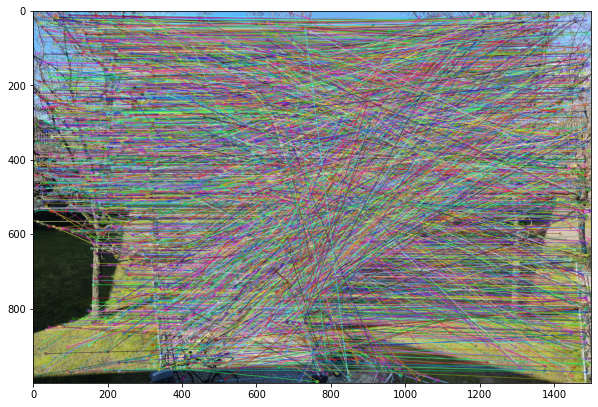

In [4]:
matches, kp1, kp2, des1, des2 = SIFT_features(im1, im2)
qm1, qm2 = points_from_matches(matches, kp1, kp2)
im3 = cv2.drawMatches(
    im1, kp1,
    im2, kp2,
    matches,
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchesThickness=1
)
plt.figure(figsize = (10, 10))
plt.imshow(im3)
plt.savefig('ex10_plot5.jpg', bbox_inches='tight',dpi=500)

If we use the ratio test with a ratio of 0.6:

In [5]:
ratio_test = False
if ratio_test:
    bf = cv2.BFMatcher()
    knn_matches = bf.knnMatch(des1, des2, k=2)
    distinctive = []
    for m, n in knn_matches:
        if m.distance < 0.6 * n.distance:
            distinctive.append(m)
    print(f"There are {len(distinctive)} distinctive matches.")
    qt1, qt2 = points_from_matches(distinctive, kp1, kp2)

    im3 = cv2.drawMatches(
        im1, kp1,
        im2, kp2,
        distinctive,
        None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchesThickness=2
    )
    plt.figure(figsize = (20,20))
    plt.imshow(im3)
plt.savefig('ex10_plot4.jpg', bbox_inches='tight',dpi=500)

<Figure size 432x288 with 0 Axes>

### 2. RANSAC for finding the homography

A homography has eight degrees of freedom (3x3, scale invariant), and each pair of points imposes two constraints (x and y).
\begin{align*}
    \textbf{q}_1 = \textbf{Hq}_2
\end{align*}
We need therefore need 4 pairs of points to estimate the homography.

In [6]:
def RANSAC_H(set1, set2, threshold, p=1-1e-16, recompute_H=True, max_iter=1000):
    M = set1.shape[1]
    m = 0
    s = 0
    N = 1
    eps = 0

    while (m < N) & (m < max_iter):
        draw = np.random.choice(list(range(M)), 4, replace=False)
        p1 = set1[:, draw]
        p2 = set2[:, draw]

        H = hest(p1,p2, norm=True)
        n_in = homography_consensus(H, set1, set2, threshold)

        if n_in >= s:
            s = n_in
            best_guess = p1, p2

        m += 1
        eps = 1 - s / M
        N = np.log(1 - p) / np.log(1 - (1 - eps) ** 2)
    
    print(f"{m} iterations")
    p1, p2 = best_guess
    H = hest(p1,p2, norm=True)
    if recompute_H:
        mask = is_H_inlier(H, set1, set2, threshold)
        print(f"Number of inliers with best guess: {np.sum(mask)}")
        H = hest(set1[:, mask],set2[:, mask],norm=True)
    print(f"Number of inliers after recomputing the homography: {np.sum(is_H_inlier(H, set1, set2, threshold))}")
    return H

def is_H_inlier(H, p1, p2, threshold):
    return dist_approximation(H, p1, p2) < threshold

def homography_consensus(H, p1, p2, threshold):
    inlier = is_H_inlier(H, p1, p2, threshold)
    return np.sum(inlier)

def dist_approximation(H, p1, p2):
    """Return an approximation of the squared distance."""
    q1 = to_inhomogeneous_v2(p1)
    q2 = to_inhomogeneous_v2(p2)
    q1_est = to_inhomogeneous_v2(H @ p2)
    q2_est = to_inhomogeneous_v2(np.linalg.inv(H) @ p1)
    return np.linalg.norm(q1 - q1_est, axis=0) ** 2 + np.linalg.norm(q2 - q2_est, axis=0) ** 2

In [7]:
threshold = 2e2
H = RANSAC_H(qm1, qm2, threshold)
H

219 iterations
Number of inliers with best guess: 964
Number of inliers after recomputing the homography: 964


array([[ 6.26775287e-01,  1.11241069e-02, -2.55092172e+02],
       [ 1.60261472e-01,  5.69677812e-01, -8.95933361e+01],
       [ 3.42124148e-04,  2.19394429e-06,  3.76731391e-01]])

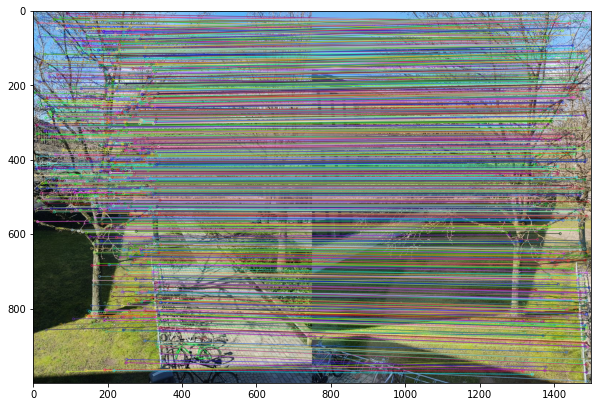

In [8]:
mask = is_H_inlier(H, qm1, qm2, threshold)
im3 = cv2.drawMatches(
    im1, kp1,
    im2, kp2,
    np.array(matches)[mask],
    None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchesThickness=1)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(im3)
plt.savefig('ex10_plot1.jpg', bbox_inches='tight',dpi=500)

### 3. Wrapping up the code

In [9]:
def estHomographyRANSAC(kp1, des1, kp2, des2, threshold=2e4):
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(des1, des2)
    qm1, qm2 = points_from_matches(matches, kp1, kp2)
    H = RANSAC_H(qm1, qm2, threshold)
    return H

### 4.  Wrapping up the image

In [10]:
def warpImage(im, H, xRange, yRange):
    """
    Take an image and a homography and
    Return the image warped with the homography
    Parameters
    ----------
    im: array
        The image from.
    H: 3 * 3 array 
        The homography from im to another image.
    xRange, yRange:
        specifies for which range of x and y values the image should be sampled.

    Returns
    -------
    imWarp: yRange * xRange array
        The transformed version of the image
    maskWarp: yRange * xRange array
        A mask that is 1 where the image is valid.
    """
    T = np.eye(3)
    T[:2, 2] = [-xRange[0], -yRange[0]]
    H = T@H
    outSize = (xRange[1]-xRange[0], yRange[1]-yRange[0])
    imWarp = cv2.warpPerspective(im, H, outSize)
    maskWarp = cv2.warpPerspective(np.ones(im.shape[:2], dtype=np.uint8), H, outSize)
    return imWarp, maskWarp

In [11]:
H = estHomographyRANSAC(kp1, des1, kp2, des2)

191 iterations
Number of inliers with best guess: 1027
Number of inliers after recomputing the homography: 1027


In [12]:
xRange = [-600, im1.shape[1] + 10]
yRange = [-150, im1.shape[0] + 150]

imWarp, maskWarp = warpImage(im2, H, xRange, yRange)

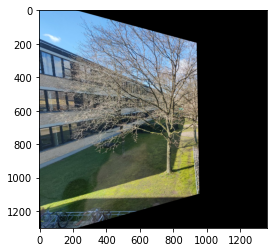

In [13]:
plt.imshow(imWarp);

### 5. Combine images

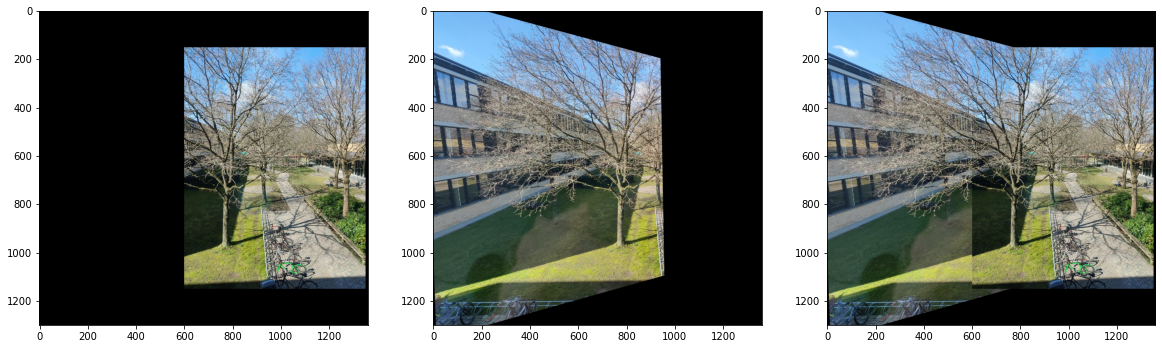

In [14]:
im1_resize = np.zeros(imWarp.shape)
im3 = imWarp.copy()

i1 = max(-yRange[0], 0)
i2 = min(im1.shape[0] + i1, yRange[1] -yRange[0])

j1 = max(-xRange[0], 0)
j2 = min(im1.shape[1] + j1, xRange[1] -xRange[0])

im1_resize[i1:i2, j1:j2] = im1[
    max(0, yRange[0]):max(0, yRange[0]) + i2 - i1,
    max(0, xRange[0]):max(0, xRange[0]) + j2 - j1
]
im3[i1:i2, j1:j2] = im1[
    max(0, yRange[0]):max(0, yRange[0]) + i2 - i1,
    max(0, xRange[0]):max(0, xRange[0]) + j2 - j1
]

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(im1_resize / 255)
ax[1].imshow(imWarp)
ax[2].imshow(im3)
plt.savefig('ex10_plot2.jpg', bbox_inches='tight',dpi=500)

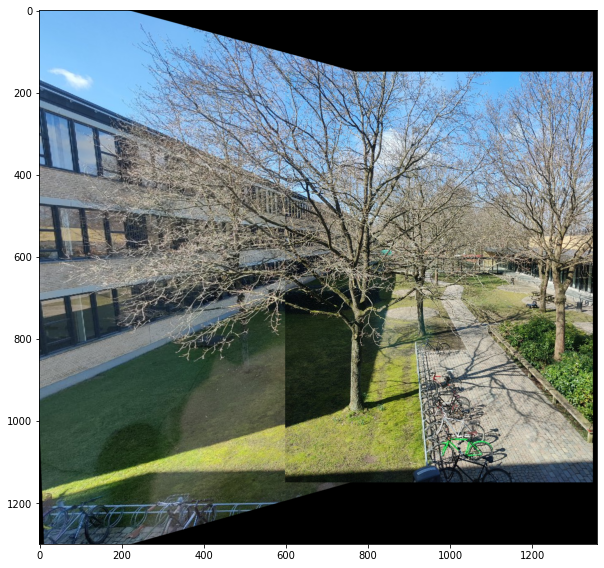

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(im3)
plt.savefig('ex10_plot3.jpg', bbox_inches='tight',dpi=500)

## Built in OpenCV

In [16]:
# Built in comparison
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist() # List of what matches were used in final.
len(src_pts), len(matchesMask)

NameError: name 'src_pts' is not defined

In [ ]:
M*1/M[0,0], H*1/H[0,0]

(array([[ 1.00000000e+00,  1.79973955e-02, -4.07008298e+02],
        [ 2.54825045e-01,  9.09212310e-01, -1.42447119e+02],
        [ 5.42913600e-04,  3.50820294e-06,  6.03164547e-01]]),
 array([[ 1.00000000e+00,  0.00000000e+00,  7.19836880e+02],
        [-4.32735945e-01,  0.00000000e+00,  7.58341496e+01],
        [-9.21048748e-04,  0.00000000e+00,  1.77071255e+00]]))

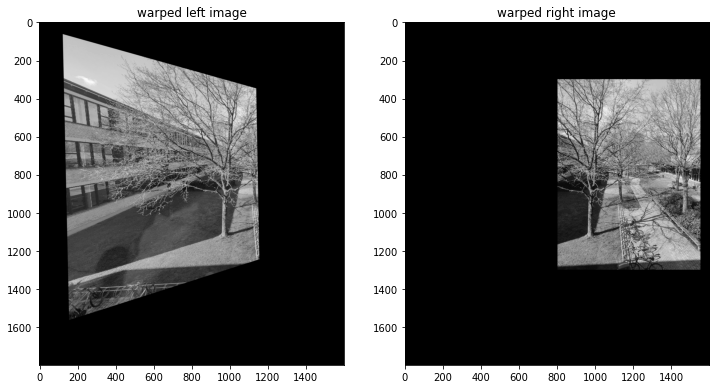

In [ ]:
#xRange = [0, left.shape[1]]
#yRange = [0, left.shape[0]]

xRange = [-800, 800]
yRange = [-300, 1500]

left_warp, left_mask = warpImage(left, M, xRange, yRange)

right_warp, right_mask = warpImage(right, np.identity(3), xRange, yRange)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].imshow(left_warp, cmap="gray")
axs[0].set_title("warped left image")
axs[1].imshow(right_warp, cmap="gray")
axs[1].set_title("warped right image");

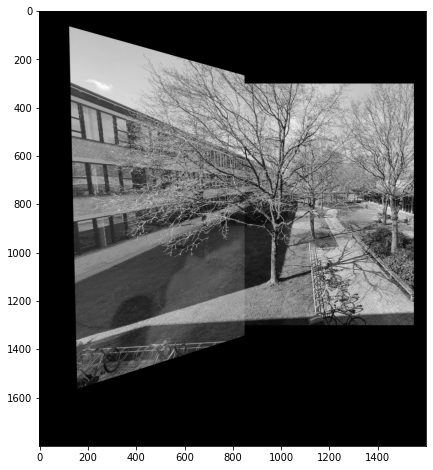

In [ ]:
# Since the right image is the base image, we use the left image as canvas, and draw the right image on top.
canvas = left_warp.copy()
canvas[:, -right.shape[1]:] = right_warp[:, -right.shape[1]:]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axs.imshow(canvas, cmap="gray");

## Optional
* Set xRange and yRange so image content is not lost
* Expand algorithm to handle 3 images
* Expand algorithm so its able to handle overplapping images (such as four images taken in rectangle)
* Implement non linear optimization for homographies